# Data Extraction and Preprocessing Functions

## Libraries

In [2]:
# import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os

## Extraction and optional preprocessing

### Basic Extraction to df
Extract individual csv files
* option to downsample
* option to save to csv

In [3]:

def extract_folder_v2(folderpath, downsample=None, save_to_csv=False, output_csv_path=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): folder containing CSV files.
      downsample (int, optional): number of rows to downsample CSVs to. Defaults to None.
      save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
      output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # optional downsample 
                if downsample:
                    df = df.sample(downsample)

                # ID column - this is the filename without the extension
                df['id'] = id

                # 'condition' column
                df['condition'] = subfolder

                # convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)


    try:
        if save_to_csv:
            if output_csv_path:
                df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        return df
    except OSError:
        print("Error saving to CSV.")


In [4]:
folderpath = '../data/depresjon'
output_csv_path = '../data/petter/downsample1000K.csv'


# downsample and store csv
#df_1000K = extract_folder_v2(folderpath, downsample=1000, save_to_csv=True, output_csv_path=output_csv_path)
# full ds, no csv
df = extract_folder_v2(folderpath)

### Add 'scores' data to df
* `Depresjon dataset` also contains additional data, in particular depression scores
* function adds 'scores' columns to dataframe
* option to save csv
* option to exclude 'control' - defaults to include

In [46]:
def add_scores(df, scores_df, merge_on_df='id', merge_on_scores='number', save_to_csv=False, output_csv_path=None, include_all_labels=True):
    """
    Adds scores data.

    Args:
        df (pd.DataFrame): extracted df.
        scores_df (pd.DataFrame):  scores df
        merge_on_df (str, optional): col in extracted df to merge on. defaults to 'id'.
        merge_on_scores (str, optional): col in scores df to merge on. defaults to 'number'.
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
        include_all_labels (bool, optional): include all labels. defaults to True. set to False to filter only label=1.

    Returns:
        pd.DataFrame: updated df with scores added.
    """

    import pandas as pd
    try:
        # Merge based on specified columns
        merged_df = pd.merge(df, scores_df, left_on=merge_on_df, right_on=merge_on_scores, how='left')
        # Fill missing values with NaN
        merged_df.fillna(value=pd.NA, inplace=True)

        # filter rows based on label
        if 'label' in merged_df.columns:
            if not include_all_labels:
                merged_df = merged_df[merged_df['label'] == 1]

        if save_to_csv:
            if output_csv_path:
                merged_df.to_csv(output_csv_path, index=False)
                print(f"Updated df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        return merged_df
    except KeyError:
        print(f"Error: '{merge_on_df}' column not found in the specified DataFrames.")
        return df


In [47]:
scores_df = pd.read_csv('../data/depresjon/scores.csv')

# add scores to downsampled df and save csv for all respondents
df_1000K_scores = add_scores(df, scores_df, save_to_csv=True, output_csv_path='../data/petter/merged_df.csv')
# add scores to full df, no csv
df_scores = add_scores(df, scores_df)



Updated df saved to ../data/petter/merged_df.csv


In [50]:

# print head where label == 0
print(df_scores[df_scores['label'] == 0].head())
# print head where label == 1
print(df_scores[df_scores['label'] == 1].head())
#print(df_scores.head())


            timestamp       date  activity          id  label      number  \
0 2003-03-18 15:00:00 2003-03-18         0  control_32      0  control_32   
1 2003-03-18 15:01:00 2003-03-18         0  control_32      0  control_32   
2 2003-03-18 15:02:00 2003-03-18         0  control_32      0  control_32   
3 2003-03-18 15:03:00 2003-03-18         0  control_32      0  control_32   
4 2003-03-18 15:04:00 2003-03-18         0  control_32      0  control_32   

   days  gender    age  afftype  melanch  inpatient edu  marriage  work  \
0    14       2  25-29      NaN      NaN        NaN           NaN   NaN   
1    14       2  25-29      NaN      NaN        NaN           NaN   NaN   
2    14       2  25-29      NaN      NaN        NaN           NaN   NaN   
3    14       2  25-29      NaN      NaN        NaN           NaN   NaN   
4    14       2  25-29      NaN      NaN        NaN           NaN   NaN   

   madrs1  madrs2  
0     NaN     NaN  
1     NaN     NaN  
2     NaN     NaN  
3     

## Preprocessing

### Extract full days only

In [5]:
# copy df 
tobe_full = df.copy()
print(tobe_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571706 entries, 0 to 1571705
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1571706 non-null  datetime64[ns]
 1   date       1571706 non-null  datetime64[ns]
 2   activity   1571706 non-null  int64         
 3   id         1571706 non-null  object        
 4   label      1571706 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 60.0+ MB
None


In [64]:
def extract_full_days_v1(df):
    """
    Extracts full days from a dataframe.

    Parameters:
    df (DataFrame): input df.

    Returns:
    DataFrame: df containing only full days (1440 rows per day).

    """
    

    # group by id and date, count rows, and filter where count equals 1440
    full_days_df = df.groupby(['id', 'date']).filter(lambda x: len(x) == 1440)

    # set index to timestamp
    full_days_df.set_index(['timestamp'], inplace=True)
    
    # print id and date combinations that don't have 1440 rows
    not_full_days = df.groupby(['id', 'date']).size().reset_index(name='count').query('count != 1440')
    print("\nid and date combinations that don't have 1440 rows and have been removed:\n")
    print(not_full_days)
    
    return full_days_df



In [87]:
full_days_df = extract_full_days_v1(tobe_full)


id and date combinations that don't have 1440 rows and have been removed:

                id       date  count
0      condition_1 2003-05-07    720
16     condition_1 2003-05-23    924
17    condition_10 2004-08-31    900
32    condition_10 2004-09-15    495
33    condition_11 2004-09-28    870
...            ...        ...    ...
1101     control_7 2003-04-23    610
1102     control_8 2003-11-04    900
1122     control_8 2003-11-24    658
1123     control_9 2003-11-11    900
1143     control_9 2003-12-01    778

[115 rows x 3 columns]


In [41]:
tobe_full = df.copy()
print(tobe_full.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1571706 entries, 1019990 to 630906
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1571706 non-null  datetime64[ns]
 1   date       1571706 non-null  datetime64[ns]
 2   activity   1571706 non-null  int64         
 3   id         1571706 non-null  object        
 4   label      1571706 non-null  int64         
 5   day_diff   1571705 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 83.9+ MB
None


In [94]:

df = tobe_full.copy()

print(df.head())




            timestamp       date  activity          id  label
0 2003-03-18 15:00:00 2003-03-18         0  control_32      0
1 2003-03-18 15:01:00 2003-03-18         0  control_32      0
2 2003-03-18 15:02:00 2003-03-18         0  control_32      0
3 2003-03-18 15:03:00 2003-03-18         0  control_32      0
4 2003-03-18 15:04:00 2003-03-18         0  control_32      0


In [46]:
import pandas as pd


def extract_full_days(df, start_time="06:00", id_col="id"):
  """
  Extracts full days from a sorted dataframe based on specified ID column.

  Args:
    df: The pandas DataFrame containing timestamp, date, id, label, and activity columns (sorted by ID and date).
    start_time: The desired start time for each day in the format "HH:MM". Defaults to "06:00".
    id_col: The column name containing unique identifiers for each individual. Defaults to "id".

  Returns:
    A new pandas DataFrame containing full days for each individual.
  """

  # Create reference table with unique dates, start and end times
  reference_table = (
      df.groupby("date")
      .agg(start_time=pd.NamedAgg(column="timestamp", aggfunc="min"))
      .reset_index()
      .assign(
          end_time=lambda x: x["start_time"] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
      )
  )

  # Merge reference table with original dataframe
  merged_df = df.merge(reference_table, on="date", how="left")

  # Filter full days by ID and row count
  full_days = (
      merged_df.groupby([id_col, "date"])
      .filter(lambda x: len(x) == 1440)
      .reset_index(drop=True)
  )

  # Conditionally drop columns (only if they exist)
  if "start_time_y" in full_days.columns:
    full_days.drop(columns=["start_time_y", "end_time_y"], inplace=True)

  return full_days


In [95]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Specify your desired start time (e.g., 06:00:00)
start_time = pd.to_datetime('2002-10-10 06:00:00')

# Calculate day numbers based on start time
df['day'] = ((df['timestamp'] - start_time) // pd.Timedelta(days=1)) + 1

# Filter rows to ensure each day has exactly 1440 rows
df = df.groupby(['id', 'day']).filter(lambda x: len(x) == 1440)


                  timestamp       date  activity           id  label  day
900     2003-03-19 06:00:00 2003-03-19         0   control_32      0  161
901     2003-03-19 06:01:00 2003-03-19         0   control_32      0  161
902     2003-03-19 06:02:00 2003-03-19         0   control_32      0  161
903     2003-03-19 06:03:00 2003-03-19         0   control_32      0  161
904     2003-03-19 06:04:00 2003-03-19         0   control_32      0  161
...                     ...        ...       ...          ...    ...  ...
1571386 2003-06-18 05:55:00 2003-06-18         0  condition_4      1  251
1571387 2003-06-18 05:56:00 2003-06-18         0  condition_4      1  251
1571388 2003-06-18 05:57:00 2003-06-18         0  condition_4      1  251
1571389 2003-06-18 05:58:00 2003-06-18         0  condition_4      1  251
1571390 2003-06-18 05:59:00 2003-06-18         0  condition_4      1  251

[1480320 rows x 6 columns]


In [99]:

# Print the resulting DataFrame
print(df.head())

              timestamp       date  activity          id  label  day
900 2003-03-19 06:00:00 2003-03-19         0  control_32      0  161
901 2003-03-19 06:01:00 2003-03-19         0  control_32      0  161
902 2003-03-19 06:02:00 2003-03-19         0  control_32      0  161
903 2003-03-19 06:03:00 2003-03-19         0  control_32      0  161
904 2003-03-19 06:04:00 2003-03-19         0  control_32      0  161


In [104]:
#print(df[(df['id'] == 'control_32')])

print(df[(df['id'] == 'control_32') & (df['day'] == 162)])

               timestamp       date  activity          id  label  day
2340 2003-03-20 06:00:00 2003-03-20         0  control_32      0  162
2341 2003-03-20 06:01:00 2003-03-20         2  control_32      0  162
2342 2003-03-20 06:02:00 2003-03-20         0  control_32      0  162
2343 2003-03-20 06:03:00 2003-03-20         0  control_32      0  162
2344 2003-03-20 06:04:00 2003-03-20         0  control_32      0  162
...                  ...        ...       ...         ...    ...  ...
3775 2003-03-21 05:55:00 2003-03-21         0  control_32      0  162
3776 2003-03-21 05:56:00 2003-03-21         0  control_32      0  162
3777 2003-03-21 05:57:00 2003-03-21         0  control_32      0  162
3778 2003-03-21 05:58:00 2003-03-21         0  control_32      0  162
3779 2003-03-21 05:59:00 2003-03-21         0  control_32      0  162

[1440 rows x 6 columns]


In [79]:
import pandas as pd

def create_reference_table(df, start_time):
    unique_dates = df["date"].unique()
    reference_table = pd.DataFrame({"date": unique_dates})
    reference_table["start_time"] = pd.to_datetime(start_time).time()
    reference_table["end_time"] = (pd.to_datetime(start_time) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)).time()
    # create start datetime column for each date
    reference_table["start_datetime"] = pd.to_datetime(reference_table["date"].astype(str) + " " + reference_table["start_time"].astype(str))
    # create end datetime column which is +23 hr 59 min from start datetime
    reference_table["end_datetime"] = reference_table["start_datetime"] + pd.Timedelta(hours=23, minutes=59)
    return reference_table
    


reference_table = create_reference_table(tobe_full, "06:00")
print(reference_table.head())



        date start_time  end_time      start_datetime        end_datetime
0 2003-03-18   06:00:00  05:59:59 2003-03-18 06:00:00 2003-03-19 05:59:00
1 2003-03-19   06:00:00  05:59:59 2003-03-19 06:00:00 2003-03-20 05:59:00
2 2003-03-20   06:00:00  05:59:59 2003-03-20 06:00:00 2003-03-21 05:59:00
3 2003-03-21   06:00:00  05:59:59 2003-03-21 06:00:00 2003-03-22 05:59:00
4 2003-03-22   06:00:00  05:59:59 2003-03-22 06:00:00 2003-03-23 05:59:00


In [81]:
# new dataframe with full days
# if timestamp is between start and end datetime, give new column 'new_date' with date value from reference table
# if not, give new column 'new_date' with NaT value
full_days_df = tobe_full.copy()
full_days_df["new_date"] = full_days_df.apply(lambda x: x["date"] if ((x["timestamp"] >= reference_table["start_datetime"]) & (x["timestamp"] <= reference_table["end_datetime"])).any() else pd.NaT, axis=1)
print(full_days_df.head())


            timestamp       date  activity          id  label   new_date
0 2003-03-18 15:00:00 2003-03-18         0  control_32      0 2003-03-18
1 2003-03-18 15:01:00 2003-03-18         0  control_32      0 2003-03-18
2 2003-03-18 15:02:00 2003-03-18         0  control_32      0 2003-03-18
3 2003-03-18 15:03:00 2003-03-18         0  control_32      0 2003-03-18
4 2003-03-18 15:04:00 2003-03-18         0  control_32      0 2003-03-18


In [90]:
# group rows by id and new_date
# filter groups where count is 1440
# reset index
full_days_df_count = full_days_df.groupby(["id", "new_date"]).size().reset_index(name="count")
full_days_df_count = full_days_df_count[full_days_df_count["count"] == 1440]
# add new column called 'day' with the day number - cumulative count of each new_date per id
full_days_df_count["day"] = full_days_df_count.groupby("id").cumcount() + 1
# merge with full_days_df
full_days_df = full_days_df.merge(full_days_df_count, on=["id", "new_date"], how="inner")
# reset index
full_days_df = full_days_df[full_days_df["new_date"].isin(full_days_df_count["new_date"])]
full_days_df = full_days_df.reset_index(drop=True)
print(full_days_df.head())


            timestamp       date  activity          id  label   new_date  \
0 2003-03-19 00:00:00 2003-03-19       120  control_32      0 2003-03-19   
1 2003-03-19 00:01:00 2003-03-19        75  control_32      0 2003-03-19   
2 2003-03-19 00:02:00 2003-03-19         5  control_32      0 2003-03-19   
3 2003-03-19 00:03:00 2003-03-19       112  control_32      0 2003-03-19   
4 2003-03-19 00:04:00 2003-03-19       199  control_32      0 2003-03-19   

   count  day  
0   1440    1  
1   1440    1  
2   1440    1  
3   1440    1  
4   1440    1  


In [93]:
# print count of rows for control_32 on 2003-03-19
print(full_days_df[(full_days_df["id"] == "control_32") & (full_days_df["new_date"] == "2003-03-19")].shape[0])

# print day 1 for control_32
print(full_days_df[(full_days_df["id"] == "control_32") & (full_days_df["day"] == 2)])

1440
               timestamp       date  activity          id  label   new_date  \
1440 2003-03-20 00:00:00 2003-03-20        37  control_32      0 2003-03-20   
1441 2003-03-20 00:01:00 2003-03-20        35  control_32      0 2003-03-20   
1442 2003-03-20 00:02:00 2003-03-20         0  control_32      0 2003-03-20   
1443 2003-03-20 00:03:00 2003-03-20        37  control_32      0 2003-03-20   
1444 2003-03-20 00:04:00 2003-03-20        84  control_32      0 2003-03-20   
...                  ...        ...       ...         ...    ...        ...   
2875 2003-03-20 23:55:00 2003-03-20         0  control_32      0 2003-03-20   
2876 2003-03-20 23:56:00 2003-03-20         0  control_32      0 2003-03-20   
2877 2003-03-20 23:57:00 2003-03-20       124  control_32      0 2003-03-20   
2878 2003-03-20 23:58:00 2003-03-20         0  control_32      0 2003-03-20   
2879 2003-03-20 23:59:00 2003-03-20         0  control_32      0 2003-03-20   

      count  day  
1440   1440    2  
1441   1

In [27]:

start_time = '06:00'
reference_df = create_reference_table(tobe_full, start_time)

In [28]:
print(reference_df.head())

        date start_time  end_time      start_datetime        end_datetime
0 2003-03-18   06:00:00  05:59:59 2003-03-18 06:00:00 2003-03-18 05:59:59
1 2003-03-19   06:00:00  05:59:59 2003-03-19 06:00:00 2003-03-19 05:59:59
2 2003-03-20   06:00:00  05:59:59 2003-03-20 06:00:00 2003-03-20 05:59:59
3 2003-03-21   06:00:00  05:59:59 2003-03-21 06:00:00 2003-03-21 05:59:59
4 2003-03-22   06:00:00  05:59:59 2003-03-22 06:00:00 2003-03-22 05:59:59


In [25]:
print(full_days_df.head())

Empty DataFrame
Columns: []
Index: []


In [84]:
full_days0600 = process_full_days(tobe_full, "06:00")

In [85]:
# print info
#print(full_days0600.info())

# print head
print(full_days0600.head())
#print(full_days0600['id'].value_counts()/1440)

# for control_3 print day == 1 and day == 2
#print(full_days0600[full_days0600['id'] == 'control_3'][full_days0600['day'] == 1])




Empty DataFrame
Columns: [timestamp, date, activity, id, label, day]
Index: []


### Removing full days with zero activity (sum)

**Revised Plan**

1. remove all 'dates' (full days) where the 'sum' of `activity` for that date is '0'
2. resample to hourly and daily to understand further data filtering
3. remove dates with little activity post resampling
4. save csvs and start new file

I noticed that even when keeping 'full days' there are instances in the data where no 'activity' is recorded for the day - or *very* little.  

For example, look at `control_1` v `condition_1` resampled to hourly frequency:

![control_1 hourly plot](./hourly_control_1.png)

![condition_1 hourly plot](./hourly_condition_1.png)

Initial investigation suggests that there needs to be some tidying up before resampling:

In [8]:
# print all ids, dates where sum of activity is less than 500
print("ids, dates where min and max of activity is less than 100:")
print(full_df.groupby(['id', 'date'])['activity'].agg(['mean','min', 'max', 'sum']).query('sum < 500'))



ids, dates where min and max of activity is less than 100:
                             mean  min  max  sum
id           date                               
condition_13 2005-08-27  0.265278    0   93  382
             2005-08-28  0.201389    0   46  290
condition_16 2005-10-10  0.044444    0   58   64
             2005-10-11  0.000000    0    0    0
             2005-10-12  0.000000    0    0    0
...                           ...  ...  ...  ...
control_32   2003-04-20  0.000000    0    0    0
             2003-04-21  0.000000    0    0    0
             2003-04-22  0.000000    0    0    0
control_8    2003-11-22  0.000000    0    0    0
             2003-11-23  0.000000    0    0    0

[112 rows x 4 columns]


#### Remove where no activity by sum per day

In [9]:
# make a copy of the original dataframe
df_copy = full_df.copy()

# group by 'id' and 'date' and calculate the sum of 'activity'
df_copy['date'] = df_copy.index.date
df_sum = df_copy.groupby(['id', 'date'])['activity'].sum()

# filter out the days with zero total activity
df_sum = df_sum[df_sum != 0]

# filter the original dataframe to only include these 'id' and 'date' combinations
df_no_zero = df_copy[df_copy.set_index(['id', 'date']).index.isin(df_sum.index)]

# make date a datetime object again
df_no_zero.loc[:,'date'] = pd.to_datetime(df_no_zero['date'])



In [10]:
# is df_no_zero a subset of full_df?
print(set(df_no_zero['date']).issubset(set(full_df['date'])))


True


Quick check to see if data has been removed:

* control 3 has 20 fewer dates of data
* df has fewer rows
* new df has no dates where sum of activity is zero

In [11]:
# count number of days for control 3 in full_df
print("Number of days for control_3 in full_df:")
print(full_df.query('id == "control_3"')['date'].nunique())
# count number of days for control 3 in df_no_zero
print("Number of days for control_3 in df_no_zero:")
print(df_no_zero.query('id == "control_3"')['date'].nunique())


Number of days for control_3 in full_df:
45
Number of days for control_3 in df_no_zero:
25


In [12]:
# compare number of rows in full_df and df_no_zero
print("Number of rows in full_df:")
print(len(full_df))
print("Number of rows in df_no_zero:")
print(len(df_no_zero))

Number of rows in full_df:
1481760
Number of rows in df_no_zero:
1380960


In [13]:
# print rows where sum of activity per date is zero in non-zero dataframe
print("Rows where sum of activity per date is zero in non-zero dataframe:")
print(df_no_zero.groupby(['id', 'date'])['activity'].sum()[df_no_zero.groupby(['id', 'date'])['activity'].sum() == 0])

Rows where sum of activity per date is zero in non-zero dataframe:
Series([], Name: activity, dtype: int64)


In [14]:
#  id, dates rows which were removed from df_copy
removed_rows = df_copy[~df_copy.set_index(['id', 'date']).index.isin(df_no_zero.set_index(['id', 'date']).index)].groupby(['id']).size().reset_index(name='count')

# print id, dates rows which were removed from df_copy
print("\nid, dates which were removed from df_copy:")
removed_rows['count'] = removed_rows['count'] / 1440
print(removed_rows.sort_values(by='count', ascending=False))



id, dates which were removed from df_copy:
              id  count
8      control_3   20.0
10    control_32   14.0
9     control_31   13.0
2      control_1    5.0
1   condition_20    3.0
4     control_17    3.0
6     control_21    3.0
0   condition_16    2.0
3     control_12    2.0
5     control_19    2.0
11     control_8    2.0
7     control_26    1.0


### Resample for tidying df 

In order to investigate, resample dataframe into: 

* hourly
* daily


In [15]:
# resample v2 - mean, median, sum
def resample2(df, resample_col, frequency):
    """
    Resamples a DataFrame based on a given timestamp column and aggregates the resampled data.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        timestamp_col (str): The name of the timestamp column in the DataFrame.
        resample_col (str): The name of the column to be resampled.
        frequency (str): The frequency at which to resample the data (e.g., 'D' for daily, 'H' for hourly).

    Returns:
        pandas.DataFrame: The resampled and aggregated DataFrame.
    """

    
    # resample data and calculate mean, sum, and median
    df_resampled = df.groupby('id')[resample_col].resample(frequency).agg(['mean', 'sum', 'median'])
    
    # reset index
    df_resampled = df_resampled.reset_index()
    
    # add label column
    df_label = df.groupby(['id', df.index.date])['label'].first()
    
    # reset index
    df_label = df_label.reset_index()
    
    # rename columns
    df_label.columns = ['id', 'date', 'label']
    
    # convert date to datetime
    df_resampled['date'] = df_resampled['timestamp'].dt.date
    
    # merge dataframes
    df_final = pd.merge(df_resampled, df_label, on=['id', 'date'])

    # change date to datetime
    df_final['date'] = pd.to_datetime(df_final['date'])
    
    return df_final


In [16]:
# resample the data into several frequencies
df = df_no_zero.copy()
hour01 = resample2(df,  'activity', 'h')
#hour02 = resample2(df,  'activity', '2h')
#hour04 = resample2(df,  'activity', '4h')
#hour06 = resample2(df,  'activity', '6h')
#hour08 = resample2(df,  'activity', '8h')
hour24 = resample2(df,  'activity', 'd')
#hour48 = resample2(df,  'activity', '2D')
#hour96 = resample2(df,  'activity', '4D')



### Remove days with (suspiciously) little activity data

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_activity_by_id(df, agg, id):
    plt.figure(figsize=(14, 6))
    df_id = df[df['id'] == id]
    sns.lineplot(x='timestamp', y= agg, hue='label', data=df_id)
    plt.title(f'{agg} Activity for ID: {id}')
    plt.show()


#### Hourly


In [18]:
# describe mean, sum, median in hourly data
print(hour01.groupby('label')[['mean']].describe())
print(hour01.groupby('label')[['sum']].describe())
print(hour01.groupby('label')[['median']].describe())


          mean                                                                 \
         count        mean         std  min        25%        50%         75%   
label                                                                           
0      14520.0  207.902938  267.920323  0.0   4.833333  70.508333  356.891667   
1       8496.0  167.410976  220.493926  0.0  10.266667  78.791667  246.870833   

                    
               max  
label               
0      4007.366667  
1      2172.950000  
           sum                                                            \
         count          mean           std  min    25%     50%       75%   
label                                                                      
0      14520.0  12474.176309  16075.219385  0.0  290.0  4230.5  21413.50   
1       8496.0  10044.658545  13229.635573  0.0  616.0  4727.5  14812.25   

                 
            max  
label            
0      240442.0  
1      130377.0  
        median    

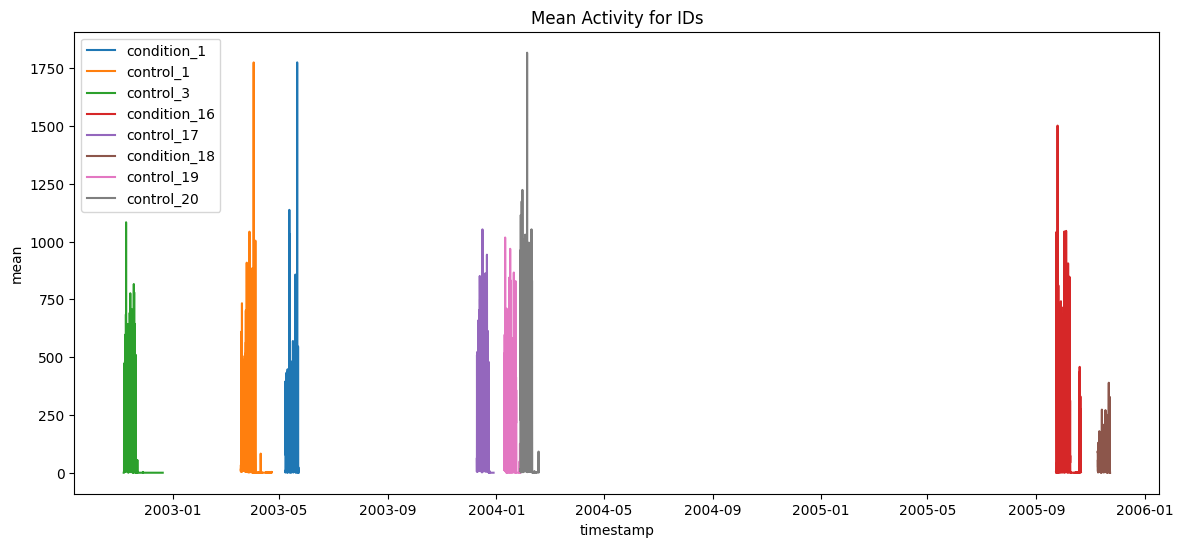

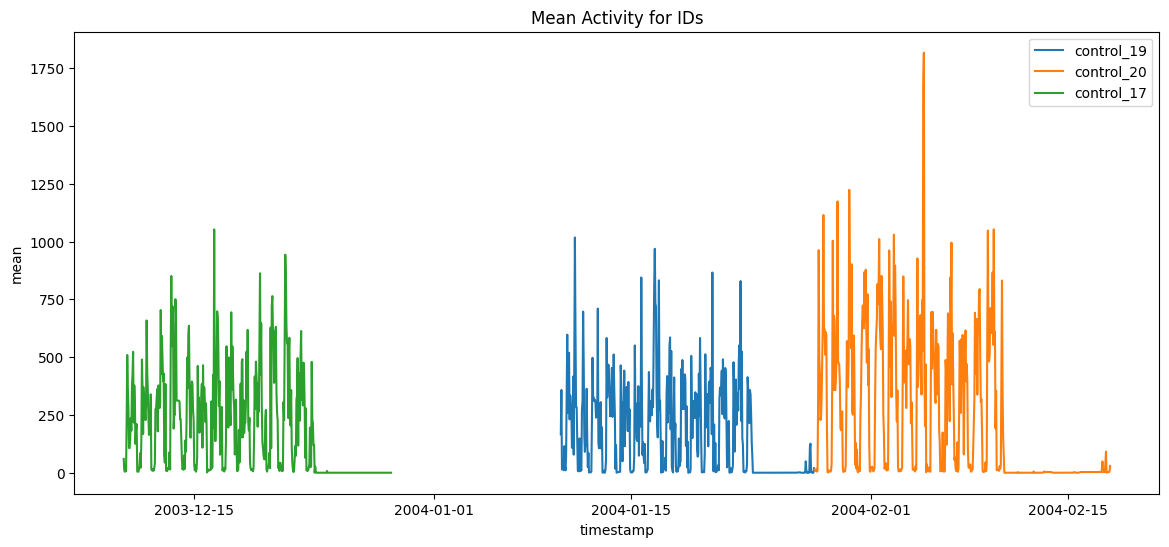

In [19]:

# plot means for hourly
ids = ['condition_1', 'control_1', 'control_3', 'condition_16', 'control_17', 'condition_18', 'control_19', 'control_20']

plt.figure(figsize=(14, 6))

for id in ids:
    df_id = hour01[hour01['id'] == id]
    sns.lineplot(x='timestamp', y='mean', data=df_id, label=id)

plt.title('Mean Activity for IDs')
plt.legend()
plt.show()

ids2 = ['control_19','control_20', 'control_17']

plt.figure(figsize=(14, 6))

for id in ids2:
    df_id = hour01[hour01['id'] == id]
    sns.lineplot(x='timestamp', y='mean', data=df_id, label=id)

plt.title('Mean Activity for IDs')
plt.legend()
plt.show()



Looking at the above - there are 'non-zero' days which do not have real activity data - as far as I can tell.  These are the flatlined tails at the end of the plots.

I think they should be removed - I will look at daily statistics (mean, median, sum).

#### Daily

        mean                                                           \
       count        mean         std       min        25%         50%   
label                                                                   
0      605.0  207.902938  146.982865  0.002083  49.755556  230.784028   
1      354.0  167.410976  106.356649  0.013194  80.928299  156.549653   

                                 sum                                      \
              75%         max  count           mean            std   min   
label                                                                      
0      312.845833  626.290278  605.0  299380.231405  211655.326079   3.0   
1      236.788194  584.284722  354.0  241071.805085  153153.575221  19.0   

                                                
             25%       50%       75%       max  
label                                           
0       71648.00  332329.0  450498.0  901858.0  
1      116536.75  225431.5  340975.0  841370.0  


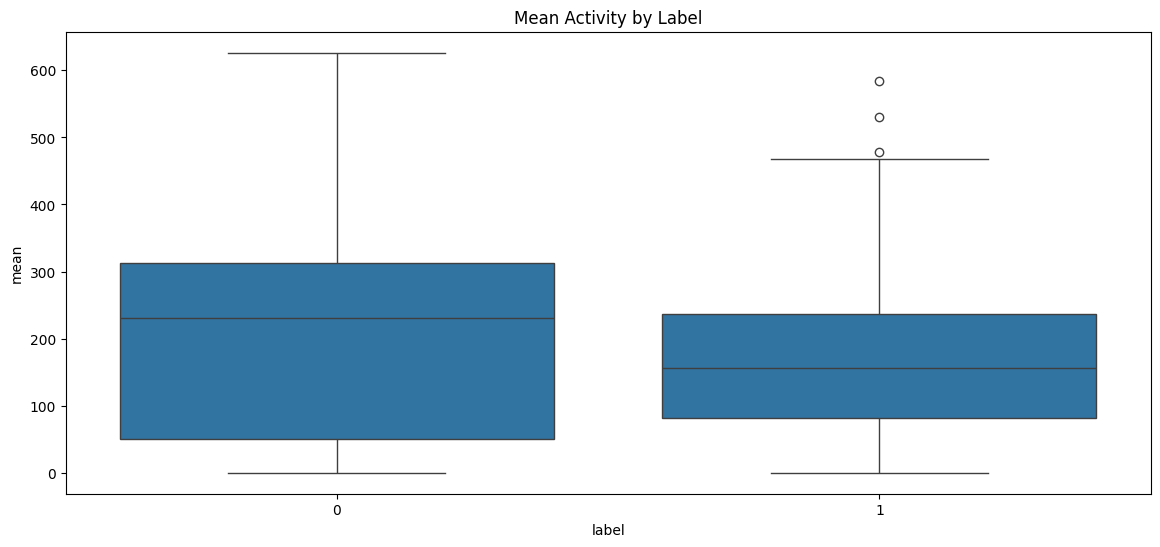

In [20]:
# describe mean, sum, median in daily data
print(hour24.groupby('label')[['mean', 'sum']].describe())

# plot sum by label
plt.figure(figsize=(14, 6))
sns.boxplot(x='label', y='mean', data=hour24)
plt.title('Mean Activity by Label')
plt.show()


In [21]:
# statistical test to check difference in mean between groups
from scipy.stats import ttest_ind
# condition group
condition = hour24[hour24['label'] == 1]['mean']
# control group
control = hour24[hour24['label'] == 0]['mean']
# perform t-test
t_stat, p_value = ttest_ind(condition, control)
print(f't-statistic: {t_stat}, p-value: {p_value}')
# interpret the result
alpha = 0.05
if p_value > alpha:
    print('Fail to reject H0 (same distributions) at alpha = {}'.format(alpha))
else:
    print('Reject H0 at alpha = {} and conclude different distributions'.format(alpha))



t-statistic: -4.534575253816302, p-value: 6.503548307843744e-06
Reject H0 at alpha = 0.05 and conclude different distributions


There is a difference between depressed and non-depressed, so I will treat them separately. 

Plot below shows the distributions.

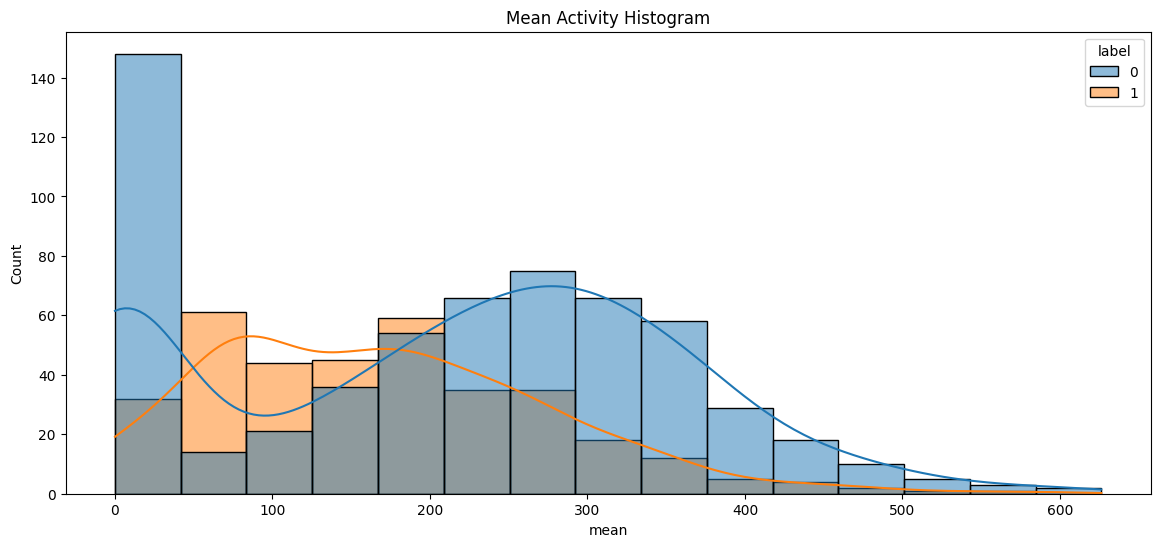

In [22]:
# plot historgram of mean activity (hour24)
plt.figure(figsize=(14, 6))
sns.histplot(data=hour24, x='mean', hue='label', kde=True)
plt.title('Mean Activity Histogram')
plt.show()


How to identify where to cut off the invalid days? 

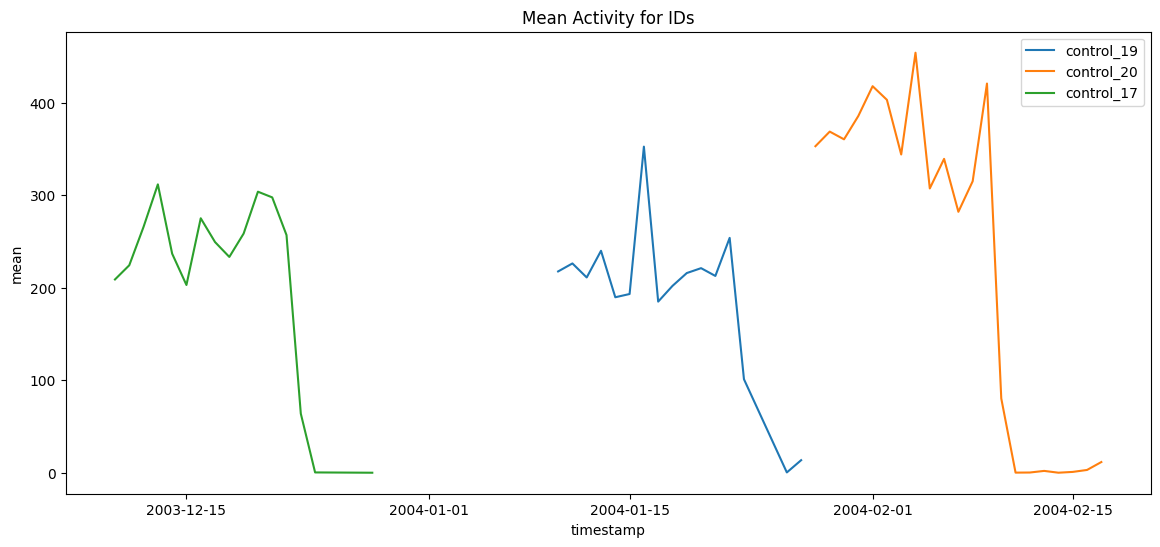

In [23]:
ids = ['condition_1', 'control_1', 'control_3', 'condition_16', 'control_17', 'condition_18', 'control_19', 'control_20']

ids2 = ['control_19','control_20', 'control_17']
plt.figure(figsize=(14, 6))

for id in ids2:
    df_id = hour24[hour24['id'] == id]
    sns.lineplot(x='timestamp', y='mean', data=df_id, label=id)

plt.title('Mean Activity for IDs')
plt.legend()
plt.show()

Investigating by individuals where activity drops off

In [24]:
# print mean activity by date 

conditions = ['condition_1', 'condition_16', 'condition_18', 'condition_23']

controls = ['control_1', 'control_3', 'control_17', 'control_19', 'control_20']

# for selected 'conditions'
for id in conditions:
    print(hour24.query(f'id == "{id}"').groupby('date')['mean'].mean())


date
2003-05-08    156.247222
2003-05-09    124.135417
2003-05-10    134.961806
2003-05-11     99.439583
2003-05-12    316.874306
2003-05-13    108.475694
2003-05-14    155.684722
2003-05-15    170.877083
2003-05-16    190.508333
2003-05-17    177.760417
2003-05-18     97.729167
2003-05-19    168.102778
2003-05-20    111.488194
2003-05-21    199.597222
2003-05-22     71.112500
Name: mean, dtype: float64
date
2005-09-23    351.057639
2005-09-24    320.678472
2005-09-25    251.465278
2005-09-26    246.621528
2005-09-27    272.051389
2005-09-28    225.793056
2005-09-29    252.787500
2005-09-30    190.786806
2005-10-01    211.275694
2005-10-02    250.957639
2005-10-03    133.880556
2005-10-04    271.892361
2005-10-05    214.324306
2005-10-06    228.692361
2005-10-07    277.776389
2005-10-08    205.296528
2005-10-09      1.212500
2005-10-10      0.044444
2005-10-13      0.034028
2005-10-14      0.013194
2005-10-15      0.187500
2005-10-16      0.357639
2005-10-17      0.472917
2005-10-18   

In [25]:
# for selected 'controls'
for id in controls:
    print(hour24.query(f'id == "{id}"').groupby('date')['mean'].mean())

date
2003-03-19    185.568056
2003-03-20    225.981250
2003-03-21    169.663194
2003-03-22    183.690972
2003-03-23    347.075000
2003-03-24    194.423611
2003-03-25    310.715278
2003-03-26    199.518750
2003-03-27    183.131944
2003-03-28    218.872222
2003-03-29    276.368750
2003-03-31    232.002778
2003-04-01    109.022917
2003-04-02    128.501389
2003-04-03     69.356250
2003-04-04     55.559028
2003-04-07      0.134722
2003-04-08      0.059722
2003-04-09      1.460417
2003-04-10      4.538889
2003-04-11      0.258333
2003-04-12      0.022917
2003-04-16      1.336806
2003-04-17      2.412500
2003-04-18      2.295833
2003-04-19      2.168750
2003-04-20      2.110417
2003-04-21      2.460417
2003-04-22      2.376389
Name: mean, dtype: float64
date
2002-11-07    190.939583
2002-11-08    249.860417
2002-11-09    300.201389
2002-11-10    264.351389
2002-11-11    322.979861
2002-11-12    225.909028
2002-11-13    279.545139
2002-11-14    277.924306
2002-11-15    290.402083
2002-11-16   

Looking at the above samples and the summary statistics, I am going to remove full days which have approximately the following means, by label: 

* label = 0 (non-depressed) - activity mean = 100
* label = 1 (depressed) - activity mean = 50

In [26]:
import matplotlib.pyplot as plt

def plot_activity_by_dates(df, id, agg, start_date, end_date, cutoff=None):
    """
    Plot the activity for a specific ID within a given date range.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        id (str): The ID to plot the activity for.
        agg (str): The aggregation method to plot (e.g., 'mean', 'sum', 'median').
        start_date (str): The start date of the date range (format: "YYYY-MM-DD").
        end_date (str): The end date of the date range (format: "YYYY-MM-DD").
        cutoff (float, optional): The cutoff value to plot as a horizontal line. Defaults to None.
    """
    filtered_df = df.query(f'id == "{id}" and date >= "{start_date}" and date <= "{end_date}"')
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df.date, filtered_df[agg])
    plt.title(f'{id} activity')
    # add horizontal line at cutoff
    if cutoff:
        plt.axhline(y=cutoff, color='r', linestyle='--')
    plt.xticks(rotation=45)
    plt.show()


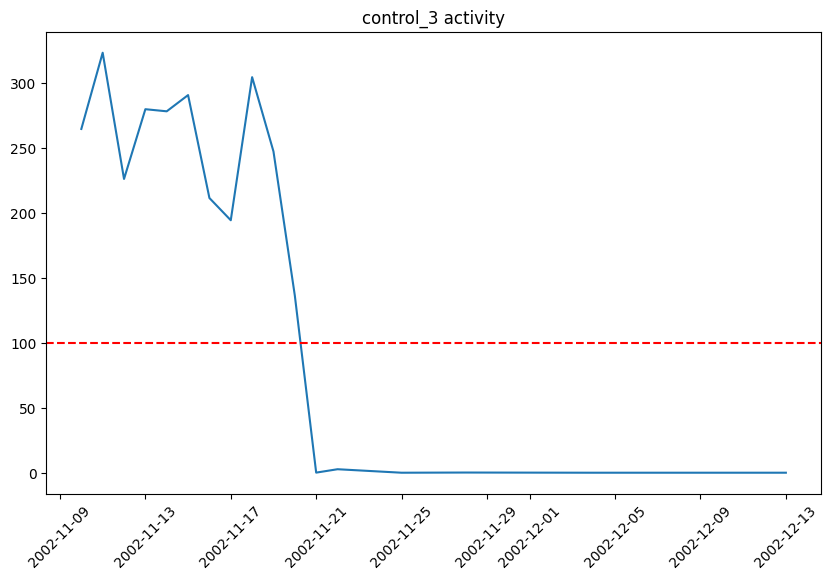

In [27]:
# plot activity for control_3
plot_activity_by_dates(hour24, 'control_3', 'mean','2002-11-10', '2002-12-14', cutoff=100)


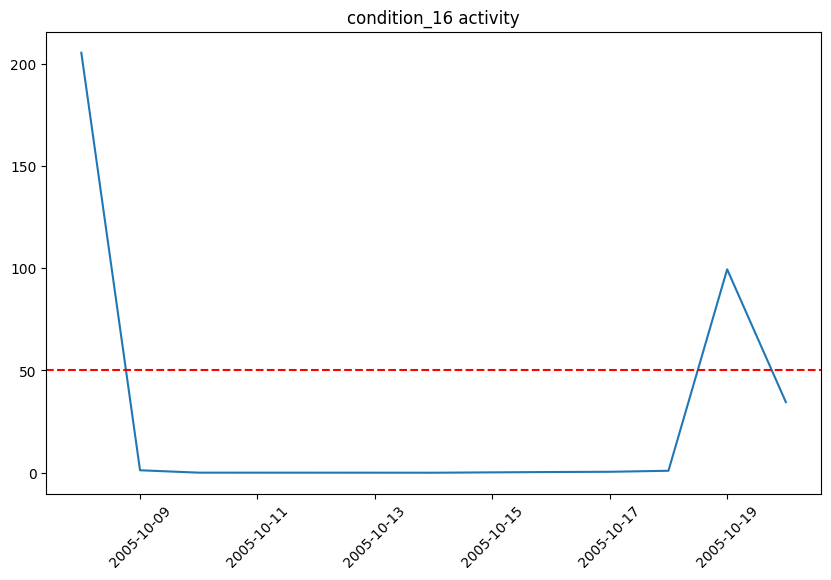

In [28]:
# plot activity for condition_16
plot_activity_by_dates(hour24, 'condition_16', 'mean','2005-10-08', '2005-10-20', cutoff=50)


#### Removal by Threshold

the 0.25 quantile is the approximate cut off.

In [29]:
# calculate 0.25 quantile of daily activity mean for each label
threshold = hour24.groupby('label')['mean'].quantile(0.25)

# sstore the thresholds separately
control_threshold = threshold[1]
condition_threshold = threshold[0]

# print the thresholds
print('Control Threshold:', control_threshold)
print('Condition Threshold:', condition_threshold)



Control Threshold: 80.92829861111112
Condition Threshold: 49.75555555555555


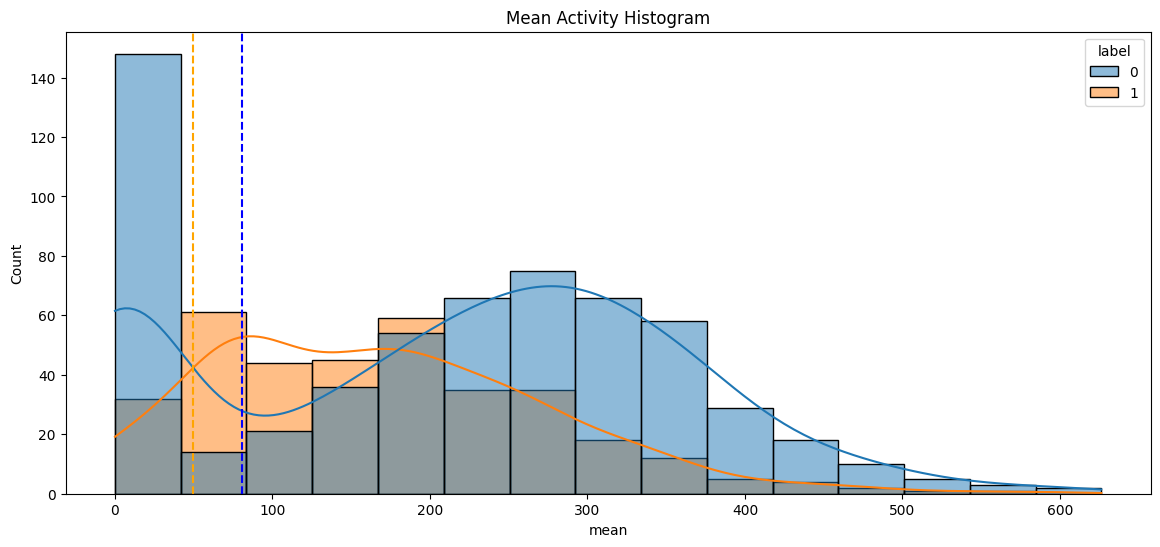

In [30]:
# plot distribution of mean activity with threshold as the cutoff for inclusion
plt.figure(figsize=(14, 6))
sns.histplot(data=hour24, x='mean', hue='label', kde=True)
plt.axvline(x=condition_threshold, color='orange', linestyle='--')
plt.axvline(x=control_threshold, color='blue', linestyle='--')
plt.title('Mean Activity Histogram')
plt.show()

In [31]:
#filter by thresholds
valid = hour24[
    (hour24['label'] == 0) & (hour24['mean'] > control_threshold) |
    (hour24['label'] == 1) & (hour24['mean'] > condition_threshold)
][['id', 'date']]

print(valid)

              id       date
0    condition_1 2003-05-08
1    condition_1 2003-05-09
2    condition_1 2003-05-10
3    condition_1 2003-05-11
4    condition_1 2003-05-12
..           ...        ...
949    control_9 2003-11-21
950    control_9 2003-11-22
951    control_9 2003-11-23
952    control_9 2003-11-24
953    control_9 2003-11-25

[765 rows x 2 columns]


In [32]:
# print number of rows being dropped
print("\nThe number of (id, date) combinations dropped: ", len(hour24) - len(valid))

# print the ids and dates dropped
print("\nIds and dates dropped: ")
dropped = hour24[~hour24.set_index(['id', 'date']).index.isin(valid.set_index(['id', 'date']).index)]
print(dropped)


The number of (id, date) combinations dropped:  194

Ids and dates dropped: 
               id  timestamp       mean    sum  median       date  label
42   condition_11 2004-10-12  37.649306  54215     0.0 2004-10-12      1
57   condition_12 2005-03-22  15.933333  22944     0.0 2005-03-22      1
73   condition_13 2005-08-27   0.265278    382     0.0 2005-08-27      1
74   condition_13 2005-08-28   0.201389    290     0.0 2005-08-28      1
94   condition_15 2005-09-05  37.477778  53968     0.0 2005-09-05      1
..            ...        ...        ...    ...     ...        ...    ...
954     control_9 2003-11-26  48.894444  70408     5.0 2003-11-26      0
955     control_9 2003-11-27   5.781250   8325     5.0 2003-11-27      0
956     control_9 2003-11-28   6.401389   9218     7.0 2003-11-28      0
957     control_9 2003-11-29   6.887500   9918     7.0 2003-11-29      0
958     control_9 2003-11-30   7.000000  10080     7.0 2003-11-30      0

[194 rows x 7 columns]


Check some samples: 

In [33]:
# print condition 16 from dropped
print("\nCondition 16 from dropped: ")
print(dropped.query('id == "condition_16"'))

# print 2005-10-19 from hour24 for condition 16
print("\n2005-10-12 from hour24 for condition 16: ")
print(hour24.query('id == "condition_16" and date == "2005-10-19"'))




Condition 16 from dropped: 
               id  timestamp       mean    sum  median       date  label
119  condition_16 2005-10-09   1.212500   1746     0.0 2005-10-09      1
120  condition_16 2005-10-10   0.044444     64     0.0 2005-10-10      1
121  condition_16 2005-10-13   0.034028     49     0.0 2005-10-13      1
122  condition_16 2005-10-14   0.013194     19     0.0 2005-10-14      1
123  condition_16 2005-10-15   0.187500    270     0.0 2005-10-15      1
124  condition_16 2005-10-16   0.357639    515     0.0 2005-10-16      1
125  condition_16 2005-10-17   0.472917    681     0.0 2005-10-17      1
126  condition_16 2005-10-18   0.967361   1393     0.0 2005-10-18      1
128  condition_16 2005-10-20  34.510417  49695     3.0 2005-10-20      1

2005-10-12 from hour24 for condition 16: 
               id  timestamp       mean     sum  median       date  label
127  condition_16 2005-10-19  99.436806  143189     3.0 2005-10-19      1


C:\Users\zoona\AppData\Local\Temp\ipykernel_14408\4270646942.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(hour24.query('id == "condition_16" and date == "2005-10-19"'))


In [34]:
# print control 20 from dropped
print("\nControl 20 from dropped: ")
print(dropped.query('id == "control_20"'))

# print 2005-02-10 from hour24 for control 20
print("\n2004-02-10 from hour24 for control 20: ")
print(hour24.query('id == "control_20" and date == "2004-02-10"'))


Control 20 from dropped: 
             id  timestamp       mean     sum  median       date  label
574  control_20 2004-02-10  80.325694  115669     0.0 2004-02-10      0
575  control_20 2004-02-11   0.111111     160     0.0 2004-02-11      0
576  control_20 2004-02-12   0.224306     323     0.0 2004-02-12      0
577  control_20 2004-02-13   1.967361    2833     3.0 2004-02-13      0
578  control_20 2004-02-14   0.018750      27     0.0 2004-02-14      0
579  control_20 2004-02-15   0.883333    1272     0.0 2004-02-15      0
580  control_20 2004-02-16   3.000000    4320     3.0 2004-02-16      0
581  control_20 2004-02-17  11.559028   16645     3.0 2004-02-17      0

2004-02-10 from hour24 for control 20: 
             id  timestamp       mean     sum  median       date  label
574  control_20 2004-02-10  80.325694  115669     0.0 2004-02-10      0


C:\Users\zoona\AppData\Local\Temp\ipykernel_14408\1513146520.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(hour24.query('id == "control_20" and date == "2004-02-10"'))


Looking at the above, some days are just above these thresholds - perhaps they should be removed? 

* to consider.

In [36]:
# new df with from df_no_zero with only valid ids and dates
df_valid = df_no_zero[df_no_zero.set_index(['id', 'date']).index.isin(valid.set_index(['id', 'date']).index)]

In [37]:
# difference in length between df_no_zero and df_valid
print("Difference in length between df_no_zero and df_valid: ", len(df_no_zero) - len(df_valid))

Difference in length between df_no_zero and df_valid:  279360


In [38]:
print(df_valid)
print(df_valid.info())

                                    date  activity           id  label
timestamp                                                             
2003-03-19 00:00:00  2003-03-19 00:00:00         0    control_1      0
2003-03-19 00:01:00  2003-03-19 00:00:00         0    control_1      0
2003-03-19 00:02:00  2003-03-19 00:00:00         0    control_1      0
2003-03-19 00:03:00  2003-03-19 00:00:00         0    control_1      0
2003-03-19 00:04:00  2003-03-19 00:00:00       175    control_1      0
...                                  ...       ...          ...    ...
2004-06-09 23:55:00  2004-06-09 00:00:00       169  condition_9      1
2004-06-09 23:56:00  2004-06-09 00:00:00       169  condition_9      1
2004-06-09 23:57:00  2004-06-09 00:00:00       169  condition_9      1
2004-06-09 23:58:00  2004-06-09 00:00:00       169  condition_9      1
2004-06-09 23:59:00  2004-06-09 00:00:00        60  condition_9      1

[1101600 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeInd

<Figure size 1400x600 with 0 Axes>

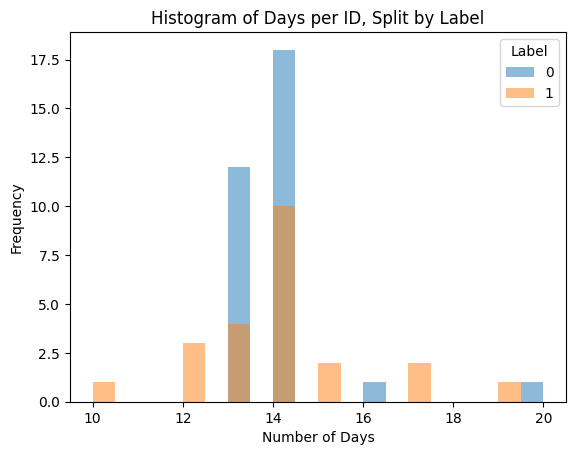

In [39]:
# count days per id in valud df
#print(df_valid.groupby('id')['date'].nunique())

# count days per id in valid df
plt.figure(figsize=(14, 6))
df_valid.groupby(['id', 'label'])['date'].nunique().unstack().plot(kind='hist', bins=20, alpha=0.5)
plt.title('Histogram of Days per ID, Split by Label')
plt.xlabel('Number of Days')
plt.ylabel('Frequency')
plt.legend(title='Label')
plt.show()



In [57]:
# save df_valid to a new csv file
df_valid.to_csv('minute01.csv', index=False)


### Resampling

In [40]:

def resample3(df, resample_col, frequency):
    """
    Resamples a DataFrame based on a given timestamp column and aggregates the resampled data.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        resample_col (str): The name of the column to be resampled.
        frequency (str): The frequency at which to resample the data (e.g., 'D' for daily, 'H' for hourly).

    Returns:
        pandas.DataFrame: The resampled and aggregated DataFrame.
    """
    # resample data and calculate mean, sum, median, std, min, max, skew, kurtosis
    df_resampled = df.groupby('id')[resample_col].resample(frequency).agg(['mean', 'sum', 'median', 'std', 'var', 'min', 'max'])
    
    # reset index
    df_resampled = df_resampled.reset_index()
    
    # add label column
    df_label = df.groupby(['id', df.index.date])['label'].first()
    
    # reset index
    df_label = df_label.reset_index()
    
    # rename columns
    df_label.columns = ['id', 'date', 'label']
    
    # convert date to datetime
    df_resampled['date'] = df_resampled['timestamp'].dt.date
    
    # merge dataframes
    df_final = pd.merge(df_resampled, df_label, on=['id', 'date'])

    # change date to datetime
    df_final['date'] = pd.to_datetime(df_final['date'])
    
    return df_final

In [41]:
# resample the data into several frequencies
df = df_valid.copy()
hour01 = resample3(df,  'activity', 'h')
hour02 = resample3(df,  'activity', '2h')
hour04 = resample3(df,  'activity', '4h')
hour06 = resample3(df,  'activity', '6h')
hour08 = resample3(df,  'activity', '8h')
hour12 = resample3(df,  'activity', '12h')
hour24 = resample3(df,  'activity', 'd')
hour48 = resample3(df,  'activity', '2D')
hour96 = resample3(df,  'activity', '4D')



#### Inspect dfs

In [42]:
# info of hour1
print(hour01.info())
# head of hour1
print(hour01.head())
# describe mean, sum, median of hour1
#print(hour01[['mean', 'sum', 'median']].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18360 entries, 0 to 18359
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         18360 non-null  object        
 1   timestamp  18360 non-null  datetime64[ns]
 2   mean       18360 non-null  float64       
 3   sum        18360 non-null  int64         
 4   median     18360 non-null  float64       
 5   std        18360 non-null  float64       
 6   var        18360 non-null  float64       
 7   min        18360 non-null  float64       
 8   max        18360 non-null  float64       
 9   date       18360 non-null  datetime64[ns]
 10  label      18360 non-null  int64         
dtypes: datetime64[ns](2), float64(6), int64(2), object(1)
memory usage: 1.5+ MB
None
            id           timestamp       mean  sum  median        std  \
0  condition_1 2003-05-08 00:00:00   8.000000  480     0.0  42.225785   
1  condition_1 2003-05-08 01:00:00   4.083333  2

In [56]:

# extract the hour from timestamp
hour01['start_hour'] = hour01['timestamp'].dt.hour

# group by date and id, find the minimum start hour
min_start_hour = hour01.groupby(['date', 'id'])['start_hour'].min()

# most common start hour across all groups
most_common_start_hour = min_start_hour.mode().values[0]

print(f"The most common start hour is: {most_common_start_hour} hour")

# print unique start hours
unique_start_hours = min_start_hour.unique()
print(f"Unique start hours: {unique_start_hours}")



The most common start hour is: 0 hour
Unique start hours: [0]


In [43]:
# info for hour6
print(hour06.info())
# head of hour6
print(hour06.head())
# describe mean, sum, median of hour6
print(hour06[['mean', 'sum', 'median']].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         3060 non-null   object        
 1   timestamp  3060 non-null   datetime64[ns]
 2   mean       3060 non-null   float64       
 3   sum        3060 non-null   int64         
 4   median     3060 non-null   float64       
 5   std        3060 non-null   float64       
 6   var        3060 non-null   float64       
 7   min        3060 non-null   float64       
 8   max        3060 non-null   float64       
 9   date       3060 non-null   datetime64[ns]
 10  label      3060 non-null   int64         
dtypes: datetime64[ns](2), float64(6), int64(2), object(1)
memory usage: 263.1+ KB
None
            id           timestamp        mean     sum  median         std  \
0  condition_1 2003-05-08 00:00:00    6.061111    2182     0.0   28.469534   
1  condition_1 2003-05-08 06:00:00  17

#### Save to csvs



In [ ]:
# save all dataframes to csv
hour01.to_csv('hour01.csv', index=False)
hour02.to_csv('hour02.csv', index=False)
hour04.to_csv('hour04.csv', index=False)
hour06.to_csv('hour06.csv', index=False)
hour08.to_csv('hour08.csv', index=False)
hour12.to_csv('hour12.csv', index=False)
hour24.to_csv('hour24.csv', index=False)
hour48.to_csv('hour48.csv', index=False)
hour96.to_csv('hour96.csv', index=False)
